# Modelo B 


por: Catalina Alvarez 

In [73]:
!pip install inflect
!pip install --upgrade wordcloud



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [74]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words('spanish'))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\MarianaLozano\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 1. Preparación del Ambiente

In [75]:
import pandas as pd
#from ydata_profiling import ProfileReport

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from nltk.tokenize import word_tokenize
from sklearn.pipeline import Pipeline
from wordcloud import WordCloud
#from num2words import num2words
import matplotlib.pyplot as plt
import re, string, unicodedata
import matplotlib

%matplotlib inline
import numpy as np
import inflect
import joblib
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\MarianaLozano\AppData\Roaming\nltk_data...


[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\MarianaLozano\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# Carga de datos

In [ ]:
df_original = pd.read_csv(r'C:\Users\Catalina\OneDrive\Documents\UNIANDES\6SEMESTRE\BI\Proyecto1-BI-1\Etapa 1\datos\fake_news_spanish.csv', sep=';', encoding='utf-8')
df_original.head()


,ID,Label,Titulo,Descripcion,Fecha
0,ID,1,'The Guardian' va con Sánchez: 'Europa necesita que su apuesta dé sus frutos',El diario británico publicó este pasado jueves un editorial sobre las próximas elecciones del 23...,02/06/2023
1,ID,0,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN DE MIRELES A CAMBIO DE OTORGARLE EL PERDÓN A JAVIE...,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN DE MIRELES A CAMBIO DE OTORGARLE EL PERDÓN A JAVIE...,01/10/2023
2,ID,1,El 'Ahora o nunca' de Joan Fuster sobre el estatuto valenciano cumple 40 años,El valencianismo convoca en Castelló su fiesta grande en conmemoración del mítico Aplec de la pl...,25/04/2022
3,ID,1,"Iglesias alienta a Yolanda Díaz, ERC y EH Bildu a negociar para 'rearmar un bloque de investidur...","En política, igual que hay que negociar con los empresarios, hay que negociar con los grupos par...",03/01/2022
4,ID,0,Puigdemont: 'No sería ninguna tragedia una repetición de las elecciones',"En una entrevista en El Punt Avui, el líder de JxCat ha desdramatizado un posible escenario en e...",09/03/2018


In [77]:
train = df_original.copy()
train.head()

,ID,Label,Titulo,Descripcion,Fecha
0,ID,1,'The Guardian' va con Sánchez: 'Europa necesita que su apuesta dé sus frutos',El diario británico publicó este pasado jueves un editorial sobre las próximas elecciones del 23...,02/06/2023
1,ID,0,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN DE MIRELES A CAMBIO DE OTORGARLE EL PERDÓN A JAVIE...,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN DE MIRELES A CAMBIO DE OTORGARLE EL PERDÓN A JAVIE...,01/10/2023
2,ID,1,El 'Ahora o nunca' de Joan Fuster sobre el estatuto valenciano cumple 40 años,El valencianismo convoca en Castelló su fiesta grande en conmemoración del mítico Aplec de la pl...,25/04/2022
3,ID,1,"Iglesias alienta a Yolanda Díaz, ERC y EH Bildu a negociar para 'rearmar un bloque de investidur...","En política, igual que hay que negociar con los empresarios, hay que negociar con los grupos par...",03/01/2022
4,ID,0,Puigdemont: 'No sería ninguna tragedia una repetición de las elecciones',"En una entrevista en El Punt Avui, el líder de JxCat ha desdramatizado un posible escenario en e...",09/03/2018


# 2. Calidad de los datos

Se van a analizar 4 dimensiones distintas con respecto a la calidad de los datos (Completitud, Validez, Unicidad y Consistencia)

# Completitud

Bajo una inspeccion sencilla, parece no haber problemas de completitud en los datos

In [78]:
train.isnull().sum()

ID              0
Label           0
Titulo         16
Descripcion     0
Fecha           0
dtype: int64

In [79]:
train.count()

ID             57063
Label          57063
Titulo         57047
Descripcion    57063
Fecha          57063
dtype: int64

In [80]:
train['Label'].value_counts()

Label
1    33158
0    23905
Name: count, dtype: int64

In [81]:
# strip all values in the column
train['Descripcion'] = train['Descripcion'].str.strip()
# count all values in the column where the value is an empty string
train['Descripcion'].isnull().sum()

np.int64(0)

# Validez 
Se identifican los siguientes problemas de validez: 
Los textos en el dataset tienen problemas, vocales con tilde han sido remplazados por caracteres no validos. 


In [82]:
def fix_encoding(text):
    replacements = {
        'Ã¡': 'á',
        'Ã©': 'é',
        'Ã­': 'í',
        'Ã³': 'ó',
        'Ãº': 'ú',
        'Ã±': 'ñ'
    }
    
    for wrong, correct in replacements.items():
        text = text.replace(wrong, correct)
    
    return text

train['Descripcion'] = train['Descripcion'].apply(fix_encoding)

Convertir la columna Titulo de float a string para aplicar los cambios de fix_encoding

In [83]:
# Convertir la columna "Titulo" de float a string
train["Titulo"] = train["Titulo"].astype(str)

# Verificar el cambio de tipo de dato
train.dtypes["Titulo"]

dtype('O')

In [84]:
train['Titulo'] = train['Titulo'].apply(fix_encoding)

In [85]:
train.head(5)

,ID,Label,Titulo,Descripcion,Fecha
0,ID,1,'The Guardian' va con Sánchez: 'Europa necesita que su apuesta dé sus frutos',El diario británico publicó este pasado jueves un editorial sobre las próximas elecciones del 23...,02/06/2023
1,ID,0,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN DE MIRELES A CAMBIO DE OTORGARLE EL PERDÓN A JAVIE...,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN DE MIRELES A CAMBIO DE OTORGARLE EL PERDÓN A JAVIE...,01/10/2023
2,ID,1,El 'Ahora o nunca' de Joan Fuster sobre el estatuto valenciano cumple 40 años,El valencianismo convoca en Castelló su fiesta grande en conmemoración del mítico Aplec de la pl...,25/04/2022
3,ID,1,"Iglesias alienta a Yolanda Díaz, ERC y EH Bildu a negociar para 'rearmar un bloque de investidur...","En política, igual que hay que negociar con los empresarios, hay que negociar con los grupos par...",03/01/2022
4,ID,0,Puigdemont: 'No sería ninguna tragedia una repetición de las elecciones',"En una entrevista en El Punt Avui, el líder de JxCat ha desdramatizado un posible escenario en e...",09/03/2018


# Unicidad 
En primera instancia, el dataset no tiene columnas unicas sigueindo alguna restriccion de negocio. Luego de una sencilla inspeccion, parece haber filas totalmente duplicadas. 

In [86]:
train.duplicated().sum()

np.int64(445)

# Consistencia 
La coluumna "ID" no es unica en su totalidad, es posible que haya inconsistencias 

In [87]:
train["ID"].nunique() == len(train)

False

# Perfilamiento de datos 

Eliminacion de datos duplicados

In [88]:
train.drop_duplicates(inplace=True)

In [89]:
train.count()

ID             56618
Label          56618
Titulo         56618
Descripcion    56618
Fecha          56618
dtype: int64

In [90]:
def mostrar_grafico1(palabras, stopwords):
    if palabras.empty:
        print("No hay palabras para mostrar en la nube.")
        return
    
    # Convertir todo a string y eliminar NaN
    palabras = palabras.dropna().astype(str)
    
    # Concatenar todas las palabras en un solo string
    comment_words = " ".join(palabras)

    wordcloud = WordCloud(
        width=600, height=600,
        background_color='white',
        stopwords=stopwords,
        min_font_size=10
    ).generate(comment_words)

    # Mostrar la imagen
    plt.figure(figsize=(8, 8), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()


In [91]:
import os
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Lista de posibles fuentes compatibles
possible_fonts = [
    "C:/Windows/Fonts/arial.ttf",  # Windows
    "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf",  # Linux
    "/System/Library/Fonts/Supplemental/Arial.ttf"  # MacOS
]

# Buscar la primera fuente disponible en el sistema
font_path = None
for font in possible_fonts:
    if os.path.exists(font):
        font_path = font
        break

if font_path is None:
    raise ValueError("⚠️ No se encontró una fuente TrueType válida en el sistema. Prueba especificar una manualmente.")
else:
    print(f"✅ Fuente seleccionada: {font_path}")
# Verificar qué fuente se está usando
def mostrar_grafico1(palabras, stopwords=[]):
    if palabras.empty:
        print("No hay palabras para mostrar en la nube.")
        return

    palabras = palabras.dropna().astype(str)
    comment_words = " ".join(palabras)

    # 🔹 Verificar que la fuente se está usando
    print(f"Usando la fuente para WordCloud: {font_path}")

    wordcloud = WordCloud(
    width=600, height=600,
    background_color='white',
    stopwords=stopwords,
    min_font_size=10
).generate(comment_words)


    # Mostrar la imagen de la nube de palabras
    plt.figure(figsize=(8, 8), facecolor=None)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()



✅ Fuente seleccionada: C:/Windows/Fonts/arial.ttf


In [92]:
import os

print(f"Ruta de la fuente utilizada: {font_path}")
print(f"¿La fuente existe?: {os.path.exists(font_path)}")


Ruta de la fuente utilizada: C:/Windows/Fonts/arial.ttf
¿La fuente existe?: True


In [93]:
print(train['Titulo'].isnull().sum())  # Contar valores nulos
print(train['Titulo'].apply(lambda x: isinstance(x, float)).sum())  # Contar valores numéricos


0
0


A continuacion, se ilustrara que palabras suelen repetirse y encontrarse en los Label's 0 y 1 

---------- Words for class: 1 ----------
Total de títulos en esta clase: 32738
Primeros valores en la clase 1: 0                          'The Guardian' va con Sánchez: 'Europa necesita que su apuesta dé sus frutos'
2                          El 'Ahora o nunca' de Joan Fuster sobre el estatuto valenciano cumple 40 años
3    Iglesias alienta a Yolanda Díaz, ERC y EH Bildu a negociar para 'rearmar un bloque de investidur...
5                 El PNV consolida su mayoría, el PSE salva los papeles y el PP sigue en la marginalidad
7      La Fiscalía pide prisión incondicional para los siete CDR por terrorismo y tenencia de explosivos
Name: Titulo, dtype: object
Usando la fuente para WordCloud: C:/Windows/Fonts/arial.ttf


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\MarianaLozano\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


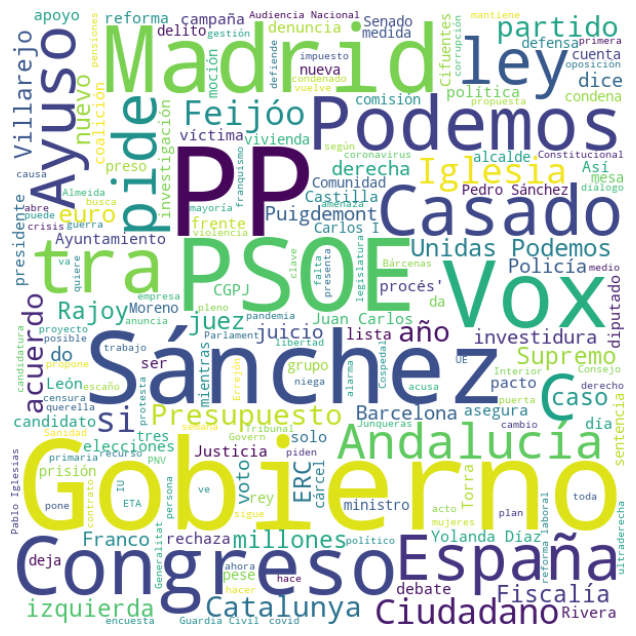

---------- Words for class: 0 ----------
Total de títulos en esta clase: 23880
Primeros valores en la clase 0: 1     REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN DE MIRELES A CAMBIO DE OTORGARLE EL PERDÓN A JAVIE...
4                                Puigdemont: 'No sería ninguna tragedia una repetición de las elecciones'
6                El exconsejero Núria Marín pide el indulto en el caso de los ERE porque no se enriqueció
9     La 'Ayusización' del BNG: Santiago Abascal instruye a los suyos a seguir la estela de la preside...
12                           Cs minimiza el caos en la gestión madrileña y cierra filas con Carlos Prieto
Name: Titulo, dtype: object
Usando la fuente para WordCloud: C:/Windows/Fonts/arial.ttf


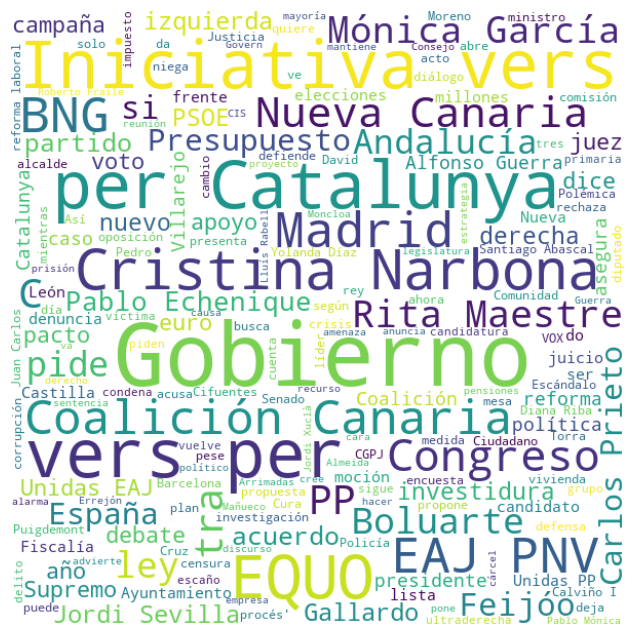

In [94]:
import nltk
from nltk.corpus import stopwords

# Descargar stopwords si no están disponibles
nltk.download('stopwords')

# Definir stopwords en español
stop_words = set(stopwords.words('spanish'))

# Asegurar que 'Titulo' no tiene valores nulos ni numéricos
train['Titulo'] = train['Titulo'].fillna("").astype(str)

for i in train['Label'].unique():
    print(f'---------- Words for class: {i} ----------')

    # Filtrar la columna 'Titulo' asegurando que solo contiene texto
    palabras = train.loc[train['Label'] == i, 'Titulo'].dropna().astype(str)

    print(f"Total de títulos en esta clase: {len(palabras)}")

    if palabras.empty:
        print(f"No hay títulos para la clase {i}, omitiendo...")
        continue  # Saltar iteración si no hay datos

    # Verificar si `palabras` contiene valores extraños
    print(f"Primeros valores en la clase {i}:", palabras.head())

    mostrar_grafico1(palabras, stopwords=stop_words)



In [95]:
train

,ID,Label,Titulo,Descripcion,Fecha
0,ID,1,'The Guardian' va con Sánchez: 'Europa necesita que su apuesta dé sus frutos',El diario británico publicó este pasado jueves un editorial sobre las próximas elecciones del 23...,02/06/2023
1,ID,0,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN DE MIRELES A CAMBIO DE OTORGARLE EL PERDÓN A JAVIE...,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN DE MIRELES A CAMBIO DE OTORGARLE EL PERDÓN A JAVIE...,01/10/2023
2,ID,1,El 'Ahora o nunca' de Joan Fuster sobre el estatuto valenciano cumple 40 años,El valencianismo convoca en Castelló su fiesta grande en conmemoración del mítico Aplec de la pl...,25/04/2022
3,ID,1,"Iglesias alienta a Yolanda Díaz, ERC y EH Bildu a negociar para 'rearmar un bloque de investidur...","En política, igual que hay que negociar con los empresarios, hay que negociar con los grupos par...",03/01/2022
4,ID,0,Puigdemont: 'No sería ninguna tragedia una repetición de las elecciones',"En una entrevista en El Punt Avui, el líder de JxCat ha desdramatizado un posible escenario en e...",09/03/2018
...,...,...,...,...,...
57058,ID,1,El Defensor del Pueblo reclama a la Comunidad de Madrid los datos de demora media para consulta ...,El gobierno regional han indicado que la atención en el día (incluyendo la atención inmediata) e...,08/06/2021
57059,ID,0,El EQUO plantea ceder la presidencia de la Comunidad de Madrid a Cs con tal de echar a Carlos Pr...,Si la higiene democrática nos lleva a esa exigencia de tener que pasar por que una persona no so...,08/09/2020
57060,ID,1,Alberto Garzón: 'Que los Borbones son unos ladrones es un hecho históricamente constatado',El coordinador federal de IU asegura que la monarquía está putrefacta.,12/07/2018
57061,ID,1,Vox exige entrar en el Gobierno de Castilla y León: 'Qué cara de vicepresidente se le está ponie...,Santiago Abascal: Vox tiene el derecho y el deber de formar gobierno en Castilla y León. El mand...,13/02/2022


# Preparacion de datos

In [96]:
X_train, y_train = train['Titulo'], train['Label'] 
display(X_train)
y_train

0                              'The Guardian' va con Sánchez: 'Europa necesita que su apuesta dé sus frutos'
1        REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN DE MIRELES A CAMBIO DE OTORGARLE EL PERDÓN A JAVIE...
2                              El 'Ahora o nunca' de Joan Fuster sobre el estatuto valenciano cumple 40 años
3        Iglesias alienta a Yolanda Díaz, ERC y EH Bildu a negociar para 'rearmar un bloque de investidur...
4                                   Puigdemont: 'No sería ninguna tragedia una repetición de las elecciones'
                                                        ...                                                 
57058    El Defensor del Pueblo reclama a la Comunidad de Madrid los datos de demora media para consulta ...
57059    El EQUO plantea ceder la presidencia de la Comunidad de Madrid a Cs con tal de echar a Carlos Pr...
57060             Alberto Garzón: 'Que los Borbones son unos ladrones es un hecho históricamente constatado'
57061    Vox exige 

0        1
1        0
2        1
3        1
4        0
        ..
57058    1
57059    0
57060    1
57061    1
57062    1
Name: Label, Length: 56618, dtype: int64

# Modificacion de Caracteres

Se pasan todos los caracteres a minusculas, se eliminan textos de puntuacion y stop words (suelen ser articulos y conectores)

1. Cambiar minusculas 

In [97]:
def to_lower(words: list[str]):
    return [word.lower() for word in words]

2. Quitar puntuacion

In [98]:
def remove_punctuation(words: list[str]):
    return [word for word in words if word.isalnum()]

3. Eliminar StopWords

In [99]:
def remove_stopwords(words: list[str]):
    stopwords = set(nltk.corpus.stopwords.words('spanish'))
    return [word for word in words if word not in stopwords]

In [100]:
def preprocessing(words):
    words = to_lower(words)
    words = remove_punctuation(words)
    words = remove_stopwords(words)
    return words

Ahora se gace un procedimiento de Tokenizacion para desglozar palabras 

In [101]:
new_X_train = X_train.apply(word_tokenize)
new_X_train = new_X_train.apply(preprocessing) 
new_X_train.head()

0                                            [guardian, va, sánchez, necesita, apuesta, dé, frutos]
1      [revelan, gobierno, negocio, liberación, mireles, cambio, otorgarle, perdón, javier, duarte]
2                                     [nunca, joan, fuster, estatuto, valenciano, cumple, 40, años]
3    [iglesias, alienta, yolanda, díaz, erc, eh, bildu, negociar, bloque, investidura, fundamental]
4                                           [puigdemont, ninguna, tragedia, repetición, elecciones]
Name: Titulo, dtype: object

In [102]:
def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = SnowballStemmer('spanish')
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

In [103]:

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

In [104]:
def stem_and_lemmatize(words):
    #words = stem_words(words)
    words = lemmatize_verbs(words)
    return words

In [105]:
new_X_train = new_X_train.apply(stem_and_lemmatize) 
new_X_train.head()

0                                            [guardian, va, sánchez, necesita, apuesta, dé, frutos]
1      [revelan, gobierno, negocio, liberación, mireles, cambio, otorgarle, perdón, javier, duarte]
2                                     [nunca, joan, fuster, estatuto, valenciano, cumple, 40, años]
3    [iglesias, alienta, yolanda, díaz, erc, eh, bildu, negociar, bloque, investidura, fundamental]
4                                           [puigdemont, ninguna, tragedia, repetición, elecciones]
Name: Titulo, dtype: object

# Separación Train/Test

In [106]:
from sklearn.model_selection import train_test_split
import numpy as np

# Definir variables de entrada (X) y salida (y)
X = df_original['Titulo']  # Se usará el título de las noticias como input
y = df_original['Label']  # La etiqueta de la noticia es la variable de salida

# División de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape



((42797,), (14266,), (42797,), (14266,))

# Cuenta de labels por cada conjunto de datos

In [107]:
from collections import Counter

train_dict = dict(Counter(y_train))
test_dict = dict(Counter(y_test))

# Mostrar conteo de etiquetas para train y test
pd.DataFrame({'Train': train_dict, 'Test': test_dict})


,Train,Test
1,24863,8295
0,17934,5971


# Vectorización de texto

In [108]:
train.dropna(inplace=True)

In [109]:
from sklearn.feature_extraction.text import CountVectorizer

# Fill missing values with empty string
X_train = X_train.fillna('')
X_test = X_test.fillna('')

cv = CountVectorizer(min_df=0., max_df=1.)
X_train_features = cv.fit_transform(X_train)
X_test_features = cv.transform(X_test)
X_train_features.shape, X_test_features.shape


((42797, 23839), (14266, 23839))

# Entrenamiento del modelo Naive Bayes

In [110]:
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB(alpha=1.)
mnb.fit(X_train_features, y_train)



MultinomialNB()

In [111]:
import joblib
import cloudpickle

if 'pipeline_model' in locals():
    serialized = cloudpickle.dumps(pipeline_model)
    with open('pipeline_model.pkl', 'wb') as f:
        f.write(serialized)
    print("Modelo guardado correctamente.")
else:
    print("Error: No se pudo guardar el modelo porque 'pipeline_model' no está definido.")


Error: No se pudo guardar el modelo porque 'pipeline_model' no está definido.


# Evaluación del modelo

In [112]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score

y_pred = mnb.predict(X_test_features)
y_pred_train = mnb.predict(X_train_features)

print('Accuracy (Train):', metrics.accuracy_score(y_train, y_pred_train))
print('Accuracy (Test):', metrics.accuracy_score(y_test, y_pred))

mnb_cv_scores = cross_val_score(mnb, X_train_features, y_train, cv=5)
mnb_cv_mean_score = np.mean(mnb_cv_scores)
print('CV Accuracy (5-fold):', mnb_cv_scores)
print('Mean CV Accuracy:', mnb_cv_mean_score)

print("\n---- Classification Report (Train) ----\n")
print(metrics.classification_report(y_train, y_pred_train))

print("\n---- Classification Report (Test) ----\n")
print(metrics.classification_report(y_test, y_pred))


Accuracy (Train): 0.8550365679837372
Accuracy (Test): 0.7937053133323987
CV Accuracy (5-fold): [0.79240654 0.79883178 0.80032714 0.79226545 0.79366748]
Mean CV Accuracy: 0.7954996789737643

---- Classification Report (Train) ----

              precision    recall  f1-score   support

           0       0.90      0.73      0.81     17934
           1       0.83      0.94      0.88     24863

    accuracy                           0.86     42797
   macro avg       0.87      0.84      0.85     42797
weighted avg       0.86      0.86      0.85     42797


---- Classification Report (Test) ----

              precision    recall  f1-score   support

           0       0.81      0.66      0.73      5971
           1       0.79      0.89      0.83      8295

    accuracy                           0.79     14266
   macro avg       0.80      0.78      0.78     14266
weighted avg       0.80      0.79      0.79     14266



# Visualización de la Matriz de Confusión

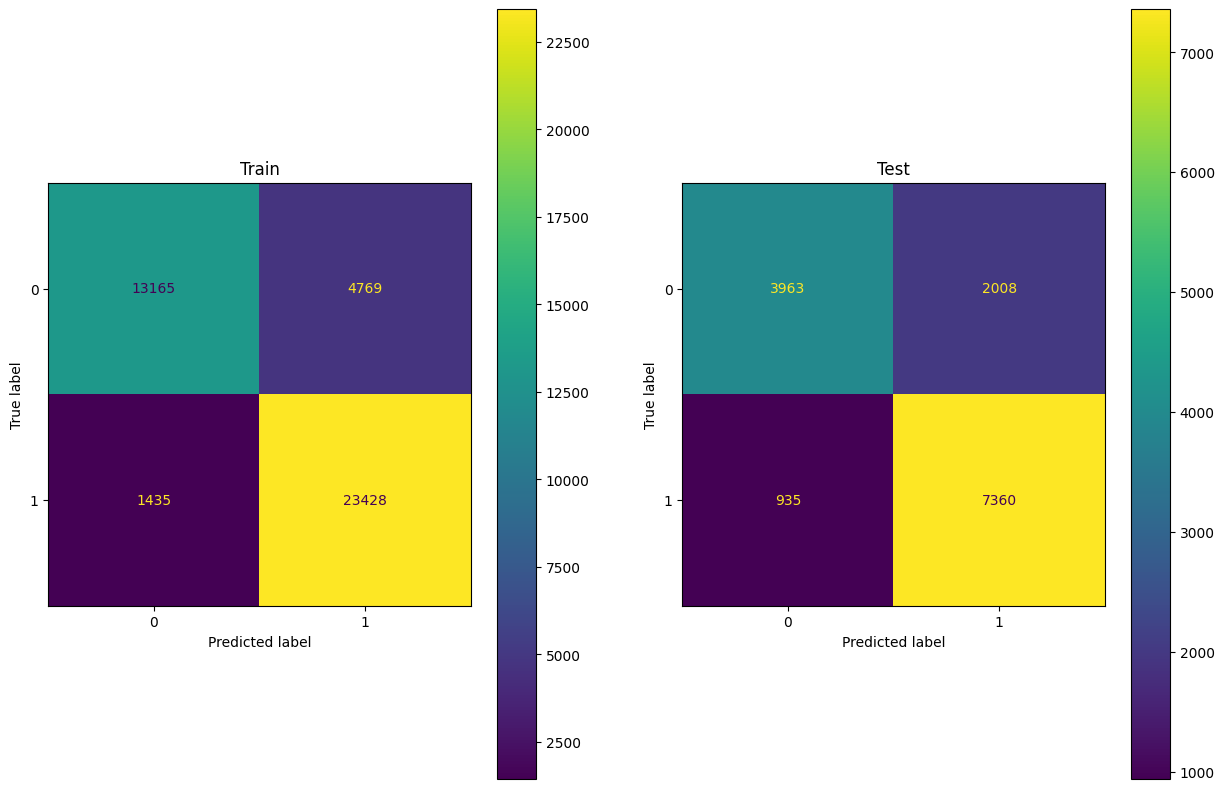

In [113]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(15, 10))

train_cm = confusion_matrix(y_train, y_pred_train, labels=mnb.classes_)
disp_train = ConfusionMatrixDisplay(confusion_matrix=train_cm, display_labels=mnb.classes_)
axes[0].set_title('Train')
disp_train.plot(ax=axes[0])

test_cm = confusion_matrix(y_test, y_pred, labels=mnb.classes_)
disp_test = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=mnb.classes_)
axes[1].set_title('Test')
disp_test.plot(ax=axes[1])

plt.show()


# Optimización del modelo con GridSearchCV

In [114]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

mnb_pipeline = Pipeline([
    ('cv', CountVectorizer()),
    ('mnb', MultinomialNB())
])

param_grid = {
    'cv__min_df': [0.0, 0.1, 0.2],
    'cv__max_df': [1.0, 0.9, 0.8],
    'mnb__alpha': [1e-5, 1e-4, 1e-2, 1e-1, 1]
}

gs_mnb = GridSearchCV(mnb_pipeline, param_grid, cv=5, n_jobs=-1, verbose=1)
gs_mnb.fit(X_train, y_train)

# Mostrar mejores parámetros
cv_results = gs_mnb.cv_results_
results_df = pd.DataFrame({'rank': cv_results['rank_test_score'],
                           'params': cv_results['params'],
                           'cv score (mean)': cv_results['mean_test_score'],
                           'cv score (std)': cv_results['std_test_score']})
results_df = results_df.sort_values(by='rank').head()
pd.set_option('display.max_colwidth', 100)
results_df

best_mnb_test_score = gs_mnb.score(X_test, y_test)
print('Test Accuracy :', best_mnb_test_score)


Fitting 5 folds for each of 45 candidates, totalling 225 fits
Test Accuracy : 0.7937053133323987


# Creación del Pipeline Final

In [115]:
from sklearn.preprocessing import FunctionTransformer
import re
from nltk.tokenize import word_tokenize

def normalize_documents(doc):
    doc = re.sub(r'[^a-zA-Z\s]', '', doc)  # Eliminar caracteres especiales
    doc = doc.lower().strip()

    tokens = word_tokenize(doc)
    doc = ' '.join(tokens)

    return doc

normalize_corpus = np.vectorize(normalize_documents)

preprocessing_pipeline = Pipeline([
    ('normalize_corpus', FunctionTransformer(normalize_corpus)),
    ('cv', CountVectorizer(min_df=0., max_df=1.)),
])

pipeline = Pipeline([
    ('preprocessing', preprocessing_pipeline),
    ('clf', MultinomialNB(alpha=1.))
])



# Evaluación del Pipeline

In [116]:
try: 
# Convertir valores nulos o float a string vacía
    df_original['Titulo'] = df_original['Titulo'].astype(str)

    X_train, X_test, y_train, y_test = train_test_split(train['Titulo'], train['Label'], test_size=0.25, random_state=1)

    vectorized_result = pipeline.named_steps['preprocessing'].fit_transform(X_train)
    pipeline.named_steps['clf'].fit(vectorized_result, y_train)

    pipeline_model = pipeline

    y_pred = pipeline_model.predict(X_test)

    mnb_cv_scores = cross_val_score(pipeline_model, X_train, y_train, cv=5)
    mnb_cv_mean_score = np.mean(mnb_cv_scores)
    print(f"Cross Validation Score (5-fold): {mnb_cv_scores}")
    print(f"Mean Cross Validation Score: {mnb_cv_mean_score}")

    print(f"Accuracy: {metrics.accuracy_score(y_test, y_pred)}")
    print(metrics.classification_report(y_test, y_pred))


except Exception as e:
    print(f"Error durante la ejecución del pipeline: {e}")

Cross Validation Score (5-fold): [0.79795125 0.79689156 0.80148357 0.80346208 0.79463024]
Mean Cross Validation Score: 0.798883741724295
Accuracy: 0.7925821264570823
              precision    recall  f1-score   support

           0       0.81      0.66      0.73      5931
           1       0.78      0.89      0.83      8224

    accuracy                           0.79     14155
   macro avg       0.80      0.77      0.78     14155
weighted avg       0.79      0.79      0.79     14155



# Serialización del Modelo

In [117]:
import joblib
import cloudpickle

serialized = cloudpickle.dumps(pipeline_model)
open('pipeline_model.pkl', 'wb').write(serialized)


1042806

In [118]:
import os

font_dir = "C:/Windows/Fonts"
fonts = [f for f in os.listdir(font_dir) if f.endswith(".ttf")]
print(fonts)


['AcadEref.ttf', 'AMDT_Symbols.ttf', 'Amgdt_IV25.ttf', 'Amgdt_IV50.ttf', 'AMGDT___.ttf', 'arial.ttf', 'arialbd.ttf', 'arialbi.ttf', 'ariali.ttf', 'ARIALUNI.ttf', 'ariblk.ttf', 'Artifakt Element Black Italic.ttf', 'Artifakt Element Black.ttf', 'Artifakt Element Bold Italic.ttf', 'Artifakt Element Bold.ttf', 'Artifakt Element Book Italic.ttf', 'Artifakt Element Book.ttf', 'Artifakt Element Hair Italic.ttf', 'Artifakt Element Hair.ttf', 'Artifakt Element Heavy Italic.ttf', 'Artifakt Element Heavy.ttf', 'Artifakt Element Italic.ttf', 'Artifakt Element Light Italic.ttf', 'Artifakt Element LIght.ttf', 'Artifakt Element Medium Italic.ttf', 'Artifakt Element Medium.ttf', 'Artifakt Element Regular.ttf', 'Artifakt Element Thin Italic.ttf', 'Artifakt Element Thin.ttf', 'bahnschrift.ttf', 'bgothl.ttf', 'bgothm.ttf', 'calibri.ttf', 'calibrib.ttf', 'calibrii.ttf', 'calibril.ttf', 'calibrili.ttf', 'calibriz.ttf', 'cambriab.ttf', 'cambriai.ttf', 'cambriaz.ttf', 'Candara.ttf', 'Candarab.ttf', 'Candarai

In [119]:
train.to_csv('train_output.csv', index=False, encoding='utf-8')